In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import math
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [3]:
#读取数据
demand_train = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021工业大数据竞赛-物料需求预测/demand_train.csv')

In [4]:
demand_train.shape

(1183595, 7)

In [7]:
demand_train.head(5).append(demand_train.tail(5))

过账日期   需求量  工厂编码  物料编码  物料品牌  物料类型  物料品类
0        2018-01-06 00:00:00  0.33  2004  1000  5000  3002  4014
1        2018-01-08 00:00:00  0.09  2010  1000  5000  3002  4014
2        2018-01-09 00:00:00  0.09  2008  1000  5000  3002  4014
3        2018-01-10 00:00:00  0.10  2010  1000  5000  3002  4014
4        2018-01-11 00:00:00  0.17  2004  1000  5000  3002  4014
1183590  2020-11-24 00:00:00  0.04  2012  1054  5001  3002  4010
1183591  2020-11-24 00:00:00  0.04  2013  1054  5001  3002  4010
1183592  2020-11-24 00:00:00  0.04  2006  1051  5001  3002  4013
1183593  2020-11-24 00:00:00  0.04  2008  1051  5001  3002  4013
1183594  2020-11-24 00:00:00  0.04  2005  1131  5001  3003  4022

In [6]:
demand_train.isnull().sum()

过账日期    0
需求量     0
工厂编码    0
物料编码    0
物料品牌    0
物料类型    0
物料品类    0
dtype: int64

In [23]:
len(set(demand_train['工厂编码']))

16

In [25]:
len(set(demand_train['物料编码']))

294

In [17]:
pivot = pd.pivot_table(demand_train,index=['工厂编码','物料编码'])
pivot = pd.DataFrame(pivot).reset_index()[['工厂编码','物料编码']]
print(pivot.shape[0])

962


In [22]:
len(set(demand_train['物料品牌']))

12

In [26]:
len(set(demand_train['物料类型']))

5

In [21]:
len(set(demand_train['物料品类']))

24

In [28]:
demand_train.groupby(['工厂编码']).agg({'需求量':'sum'})

需求量
工厂编码            
2000  457073.970
2001   83174.485
2002  159597.286
2003   95355.520
2004  119408.020
2005  113991.810
2006   81576.210
2007   80122.550
2008   82385.340
2009   80534.790
2010  226893.070
2011  352226.780
2012   67712.860
2013   95113.820
2014  110234.665
2015  113022.220

In [32]:
demand_train.groupby(['物料编码','物料品牌']).agg({'需求量':'count'}).shape[0]

294

In [40]:
demand_train.sort_values(by='需求量')

过账日期    需求量  工厂编码  物料编码  物料品牌  物料类型  物料品类
159088  2018-12-15 00:00:00   0.00  2003  1044  5001  3002  4008
33433   2018-12-15 00:00:00   0.00  2001  1029  5001  3002  4006
18245   2018-12-15 00:00:00   0.00  2001  1027  5001  3002  4014
291735  2018-12-15 00:00:00   0.00  2001  1054  5001  3002  4010
159080  2018-12-15 00:00:00   0.00  2010  1044  5001  3002  4008
...                     ...    ...   ...   ...   ...   ...   ...
657408  2019-09-08 00:00:00  75.40  2009  1159  5001  3003  4001
723780  2019-11-14 00:00:00  75.60  2009  1159  5001  3003  4001
617984  2019-07-27 00:00:00  79.20  2014  1186  5010  3003  4001
552695  2019-05-26 00:00:00  83.80  2014  1186  5010  3003  4001
727516  2019-11-17 00:00:00  88.68  2010  1031  5001  3002  4010

[1183595 rows x 7 columns]

In [4]:
data = demand_train.copy()
# 重命名
data = data.rename(columns={'过账日期':'date','需求量':'label','工厂编码':'f_code','物料编码':'m_code','物料品牌':'brand','物料类型':'cat_f','物料品类':'cat_son'})

# 拆分日期，编码物料需求所属月份
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].apply(lambda x : x.day)
data['month'] = data['date'].apply(lambda x : x.month)
data['year'] = data['date'].apply(lambda x : x.year)

#如果日期在12月24日之后，则划为下一年1月
#如果日期在1月-11月的24日之后，则划为下一月

# 月份+1
data['month_id'] = list(map(lambda x,y:y+1 if (x>24)and(y==12) else y,data['day'],data['month']))
# 年+1
data['sales_year'] = list(map(lambda y,z:z+1 if y==13 else z,data['month_id'],data['year']))
# 再把13月变为1月
data['month_id'] = list(map(lambda y:1 if y==13 else y,data['month_id']))

#编码time_id
data['time_id'] = list(map(lambda x,y:(x-2018)*12+y,data['sales_year'],data['month_id']))

# 删除多余特征
data.drop(['day','month','year','date'],axis=1,inplace=True)

In [58]:
set(data['time_id'])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35}

In [66]:
#合并每个月的物料需求
data = data.groupby(['id','f_code','m_code','brand','cat_f','cat_son','sales_year','month_id','time_id']).agg({'label':'sum'}).reset_index()

In [67]:
data

id  f_code  m_code  brand  cat_f  cat_son  sales_year  month_id  \
0      20001001    2000    1001   5000   3002     4006        2018         1   
1      20001001    2000    1001   5000   3002     4006        2018         2   
2      20001001    2000    1001   5000   3002     4006        2018         3   
3      20001001    2000    1001   5000   3002     4006        2018         4   
4      20001001    2000    1001   5000   3002     4006        2018         5   
...         ...     ...     ...    ...    ...      ...         ...       ...   
14940  20151253    2015    1253   5000   3002     4013        2020         9   
14941  20151253    2015    1253   5000   3002     4013        2020        10   
14942  20151253    2015    1253   5000   3002     4013        2020        11   
14943  20151255    2015    1255   5001   3002     4013        2020         3   
14944  20151255    2015    1255   5001   3002     4013        2020         4   

       time_id  label  
0            1  12.53  
1            2  16.08  
2            3   4.71  
3            4  17.69  
4            5   7.97  
...        ...    ...  
14940       33  19.17  
14941       34  30.44  
14942       35  10.76  
14943       27  68.44  
14944       28  11.08  

[14945 rows x 10 columns]

In [66]:
w.groupby(['time_id']).agg({'m_code':'count'}).rename(columns={'m_code':'m_code_count'}).reset_index()

time_id  m_code_count
0         1           353
1         2           338
2         3           345
3         4           336
4         5           338
5         6           339
6         7           336
7         8           334
8         9           322
9        10           313
10       11           309
11       12           291
12       13           353
13       14           338
14       15           638
15       16           629
16       17           639
17       18           639
18       19           573
19       20           515
20       21           494
21       22           468
22       23           446
23       24           455
24       25           430
25       26           418
26       27           450
27       28           449
28       29           462
29       30           469
30       31           458
31       32           466
32       33           451
33       34           425
34       35           408
35       36           392

In [67]:
len(set(w.m_code))

294

In [71]:
w.shape

(15419, 9)

In [101]:
wm = w.groupby(['f_code','m_code']).agg({'time_id':'min'}).rename(columns={'time_id':'time_id_min'}).reset_index()
wm2 = w.groupby(['f_code','m_code']).agg({'time_id':'max'}).rename(columns={'time_id':'time_id_max'}).reset_index()

In [102]:
wc = w.groupby(['f_code','m_code']).agg({'time_id':'count'}).rename(columns={'time_id':'time_id_count'}).reset_index()

In [105]:
w_merge = pd.merge(wm,wm2,on=['f_code','m_code'])

In [106]:
w_merge

f_code  m_code  time_id_min  time_id_max
0      2000    1001            1           35
1      2000    1003            1           36
2      2000    1006           15           18
3      2000    1010           15           23
4      2000    1014            1           36
..      ...     ...          ...          ...
957    2015    1117           16           16
958    2015    1120           15           18
959    2015    1252           24           36
960    2015    1253           32           35
961    2015    1255           27           28

[962 rows x 4 columns]

In [107]:
w_merge_2 = pd.merge(w_merge,wc,on=['f_code','m_code'])

In [108]:
w_merge_2.head(10).append(w_merge_2.tail(10))

f_code  m_code  time_id_min  time_id_max  time_id_count
0      2000    1001            1           35             35
1      2000    1003            1           36             36
2      2000    1006           15           18              4
3      2000    1010           15           23              9
4      2000    1014            1           36             19
5      2000    1019           15           15              1
6      2000    1020           15           36             10
7      2000    1021            1           36             16
8      2000    1027            1           36             36
9      2000    1029            1           36             36
952    2015    1088           16           20              5
953    2015    1089            1           36             36
954    2015    1090            1           36             36
955    2015    1091            1           36             36
956    2015    1114           15           18              3
957    2015    1117           16           16              1
958    2015    1120           15           18              2
959    2015    1252           24           36             13
960    2015    1253           32           35              4
961    2015    1255           27           28              2

In [111]:
w_merge_2['time_diff'] = w_merge_2['time_id_max']-w_merge_2['time_id_min']+1

In [112]:
w_merge_2.head(10).append(w_merge_2.tail(10))

f_code  m_code  time_id_min  time_id_max  time_id_count  time_diff
0      2000    1001            1           35             35         35
1      2000    1003            1           36             36         36
2      2000    1006           15           18              4          4
3      2000    1010           15           23              9          9
4      2000    1014            1           36             19         36
5      2000    1019           15           15              1          1
6      2000    1020           15           36             10         22
7      2000    1021            1           36             16         36
8      2000    1027            1           36             36         36
9      2000    1029            1           36             36         36
952    2015    1088           16           20              5          5
953    2015    1089            1           36             36         36
954    2015    1090            1           36             36         36
955    2015    1091            1           36             36         36
956    2015    1114           15           18              3          4
957    2015    1117           16           16              1          1
958    2015    1120           15           18              2          4
959    2015    1252           24           36             13         13
960    2015    1253           32           35              4          4
961    2015    1255           27           28              2          2

In [113]:
w_merge_2[w_merge_2['time_id_count']==w_merge_2['time_diff']].shape[0]

648

In [116]:
data.sort_values(by='label',ascending=False).head(50)

label  f_code  m_code  brand  cat_f  cat_son  sales_year  month_id  \
727516  88.68    2010    1031   5001   3002     4010        2019        11   
552695  83.80    2014    1186   5010   3003     4001        2019         6   
617984  79.20    2014    1186   5010   3003     4001        2019         8   
723780  75.60    2009    1159   5001   3003     4001        2019        11   
657408  75.40    2009    1159   5001   3003     4001        2019         9   
678260  70.00    2003    1233   5010   3000     4015        2019        10   
558014  68.80    2014    1186   5010   3003     4001        2019         6   
772062  68.00    2013    1189   5010   3003     4001        2020         1   
517638  67.00    2011    1054   5001   3002     4010        2019         5   
765794  65.84    2013    1189   5010   3003     4001        2020        12   
793559  65.80    2010    1186   5010   3003     4001        2020         2   
759496  64.40    2013    1189   5010   3003     4001        2019        12   
432947  64.00    2010    1186   5010   3003     4001        2019         2   
486997  64.00    2002    1071   5009   3002     4009        2019         4   
789923  64.00    2000    1145   5010   3003     4000        2020         2   
788918  63.68    2013    1186   5010   3003     4001        2020         1   
559976  62.80    2014    1175   5005   3003     4001        2019         6   
548173  62.32    2014    1186   5010   3003     4001        2019         5   
554358  62.00    2014    1186   5010   3003     4001        2019         6   
725109  61.80    2010    1186   5010   3003     4001        2019        11   
655178  60.28    2009    1159   5001   3003     4001        2019         9   
595319  59.20    2014    1186   5010   3003     4001        2019         7   
659198  58.00    2014    1186   5010   3003     4001        2019         9   
459798  56.32    2007    1031   5001   3002     4010        2019         3   
677190  56.20    2003    1233   5010   3000     4015        2019        10   
428844  56.07    2000    1145   5010   3003     4000        2019         2   
594239  56.00    2001    1159   5001   3003     4001        2019         7   
590446  55.72    2000    1186   5010   3003     4001        2019         7   
787890  55.60    2013    1186   5010   3003     4001        2020         1   
576826  55.20    2014    1186   5010   3003     4001        2019         6   
614973  55.00    2002    1068   5009   3002     4006        2019         7   
790754  55.00    2000    1145   5010   3003     4000        2020         2   
389246  54.12    2010    1186   5010   3003     4001        2018         2   
793552  54.00    2010    1186   5010   3003     4001        2020         2   
556699  54.00    2001    1159   5001   3003     4001        2019         6   
558431  53.60    2000    1054   5001   3002     4010        2019         6   
470581  53.40    2000    1054   5001   3002     4010        2019         4   
784121  53.20    2013    1189   5010   3003     4001        2020         1   
740821  52.72    2010    1186   5010   3003     4001        2019        12   
786554  52.64    2013    1189   5010   3003     4001        2020         1   
647736  52.16    2000    1145   5010   3003     4000        2019         9   
614974  52.00    2002    1069   5009   3002     4005        2019         7   
764727  51.20    2013    1186   5010   3003     4001        2020        12   
676472  51.00    2009    1159   5001   3003     4001        2019        10   
725442  50.80    2014    1186   5010   3003     4001        2019        11   
586177  50.80    2014    1186   5010   3003     4001        2019         6   
559284  50.44    2007    1031   5001   3002     4010        2019         6   
622090  50.00    2014    1186   5010   3003     4001        2019         8   
542510  50.00    2001    1003   5000   3002     4005        2019         5   
559652  49.24    2011    1054   5001   3002     4010        2019         6   

        time_id  
727516     

In [10]:
import itertools

In [28]:
pd.DataFrame(itertools.product(list(set(data['id'])),list(set(data['time_id']))),columns=['id','time_id'])

id  time_id
0      20031025        1
1      20031025        2
2      20031025        3
3      20031025        4
4      20031025        5
...         ...      ...
34627  20091040       32
34628  20091040       33
34629  20091040       34
34630  20091040       35
34631  20091040       36

[34632 rows x 2 columns]

In [60]:
data['id'] = data['f_code'].astype(str)+data['m_code'].astype(str)

In [48]:
data[(data['time_id']==36)&(data['m_code']==1010)]

label  f_code  m_code  brand  cat_f  cat_son  sales_year  month_id  \
762216   2.60    2004    1010   5000   3002     4013        2020        12   
762404   0.28    2008    1010   5000   3002     4013        2020        12   
762518   1.92    2010    1010   5000   3002     4013        2020        12   
763304   0.40    2007    1010   5000   3002     4013        2020        12   
763376   0.60    2009    1010   5000   3002     4013        2020        12   
766175   0.52    2001    1010   5000   3002     4013        2020        12   
766472   4.00    2004    1010   5000   3002     4013        2020        12   
766793   0.56    2010    1010   5000   3002     4013        2020        12   
768112   0.40    2010    1010   5000   3002     4013        2020        12   
768116   2.12    2010    1010   5000   3002     4013        2020        12   
769372   0.52    2008    1010   5000   3002     4013        2020        12   
770199   0.80    2001    1010   5000   3002     4013        2020        12   
770389   0.04    2001    1010   5000   3002     4013        2020        12   

        time_id  
762216       36  
762404       36  
762518       36  
763304       36  
763376       36  
766175       36  
766472       36  
766793       36  
768112       36  
768116       36  
769372       36  
770199       36  
770389       36

In [46]:
data.iloc[770389]

label            0.04
f_code        2001.00
m_code        1010.00
brand         5000.00
cat_f         3002.00
cat_son       4013.00
sales_year    2020.00
month_id        12.00
time_id         36.00
Name: 770389, dtype: float64

In [49]:
print(data.iloc[770389])

label            0.04
f_code        2001.00
m_code        1010.00
brand         5000.00
cat_f         3002.00
cat_son       4013.00
sales_year    2020.00
month_id        12.00
time_id         36.00
Name: 770389, dtype: float64


In [95]:
d_all = pd.DataFrame(itertools.product(list(set(data['id'])),list(set(data['time_id']))),columns=['id','time_id'])
d_pivot = pd.pivot_table(data,index=['id','f_code','m_code','brand','cat_f','cat_son'])
d_c = pd.DataFrame(d_pivot).reset_index()[['id','f_code','m_code','brand','cat_f','cat_son']]

In [96]:
d_all = pd.merge(d_all,d_c,on=['id'],how='left')

In [97]:
d_all

id  time_id  f_code  m_code  brand  cat_f  cat_son
0      20031025        1    2003    1025   5001   3002     4014
1      20031025        2    2003    1025   5001   3002     4014
2      20031025        3    2003    1025   5001   3002     4014
3      20031025        4    2003    1025   5001   3002     4014
4      20031025        5    2003    1025   5001   3002     4014
...         ...      ...     ...     ...    ...    ...      ...
33665  20091040       31    2009    1040   5001   3002     4014
33666  20091040       32    2009    1040   5001   3002     4014
33667  20091040       33    2009    1040   5001   3002     4014
33668  20091040       34    2009    1040   5001   3002     4014
33669  20091040       35    2009    1040   5001   3002     4014

[33670 rows x 7 columns]

In [99]:
#拼接'sales_year','month_id'
m_pivot = pd.pivot_table(data,index=['time_id','sales_year','month_id'])
d_m = pd.DataFrame(m_pivot).reset_index()[['time_id','sales_year','month_id']]
d_all = pd.merge(d_all,d_m,on=['time_id'],how='left')

In [100]:
d_all

id  time_id  f_code  m_code  brand  cat_f  cat_son  sales_year  \
0      20031025        1    2003    1025   5001   3002     4014        2018   
1      20031025        2    2003    1025   5001   3002     4014        2018   
2      20031025        3    2003    1025   5001   3002     4014        2018   
3      20031025        4    2003    1025   5001   3002     4014        2018   
4      20031025        5    2003    1025   5001   3002     4014        2018   
...         ...      ...     ...     ...    ...    ...      ...         ...   
33665  20091040       31    2009    1040   5001   3002     4014        2020   
33666  20091040       32    2009    1040   5001   3002     4014        2020   
33667  20091040       33    2009    1040   5001   3002     4014        2020   
33668  20091040       34    2009    1040   5001   3002     4014        2020   
33669  20091040       35    2009    1040   5001   3002     4014        2020   

       month_id  
0             1  
1             2  
2             3  
3             4  
4             5  
...         ...  
33665         7  
33666         8  
33667         9  
33668        10  
33669        11  

[33670 rows x 9 columns]

In [102]:
data = pd.merge(d_all,data,on=['id','time_id','f_code','m_code','brand','cat_f','cat_son','sales_year','month_id'],how='left').sort_values(by=['id','time_id'],ascending=True).reset_index(drop=True)

In [103]:
data.fillna(0,inplace=True)

In [105]:
r_all = data.groupby(['time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

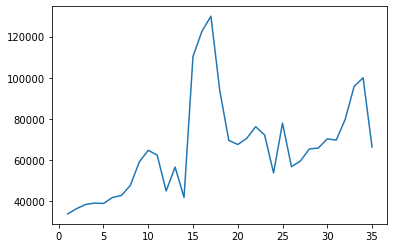

In [106]:
x=r_all['time_id']
y=r_all['sum']
plt.plot(x,y)
plt.show()

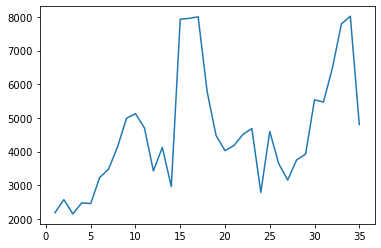

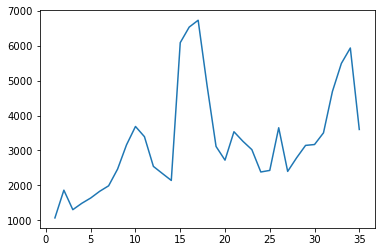

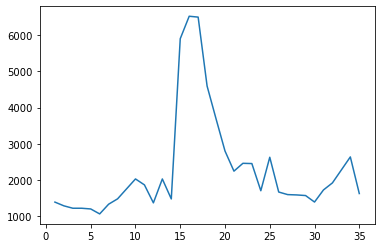

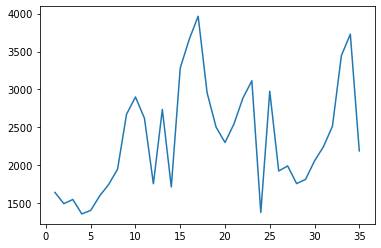

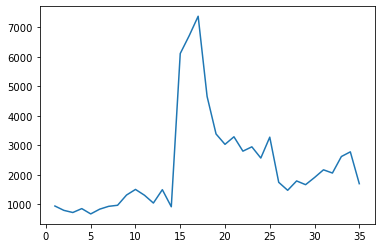

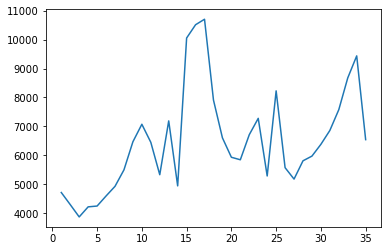

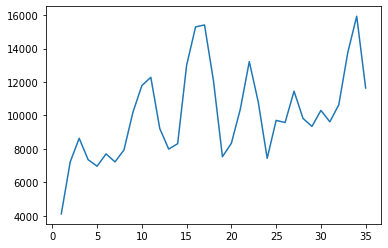

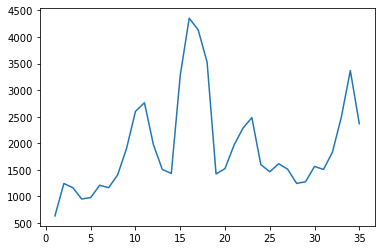

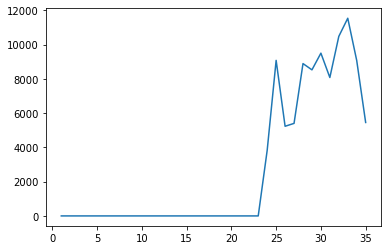

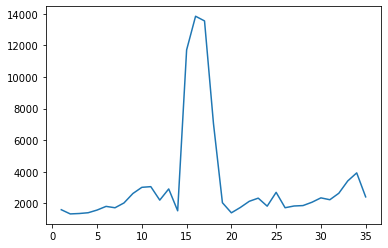

In [108]:
r_f = data.groupby(['f_code','time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

for f in list(set(data['f_code'])):
	x=r_f[r_f['f_code']==f]['time_id']
	y=r_f[r_f['f_code']==f]['sum']
	plt.plot(x,y,label=str(f))
	plt.show()

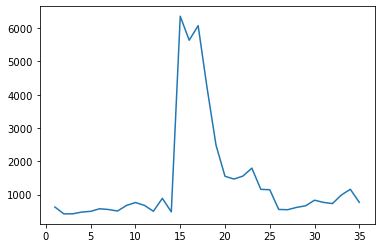

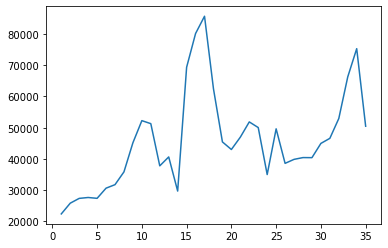

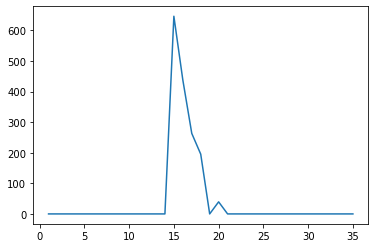

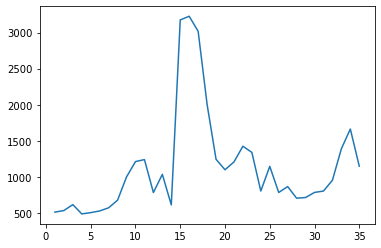

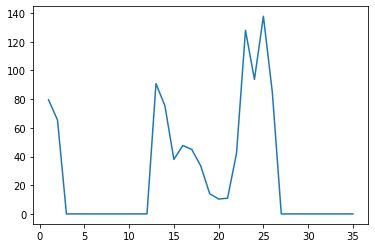

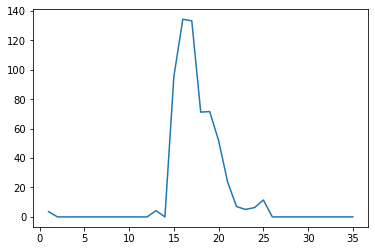

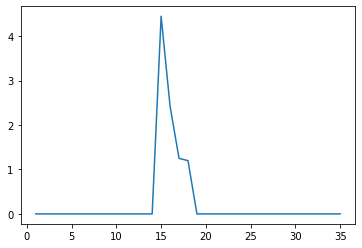

In [111]:
#品牌
r_b = data.groupby(['brand','time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

for f in list(set(data['brand'])):
	x=r_b[r_b['brand']==f]['time_id']
	y=r_b[r_b['brand']==f]['sum']
	plt.plot(x,y,label=str(f))
	plt.show()

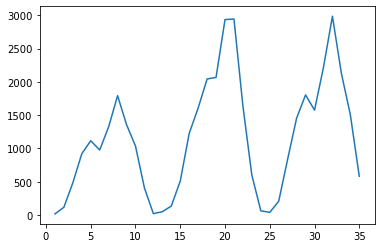

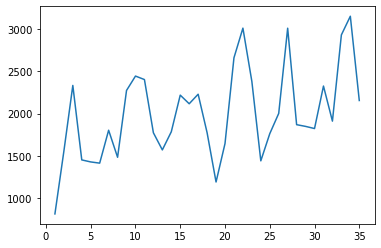

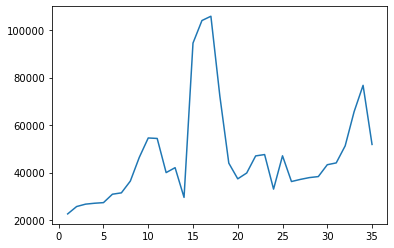

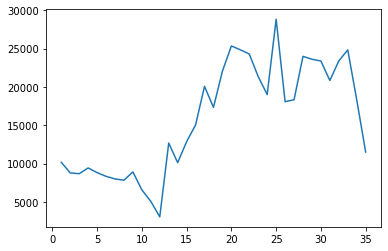

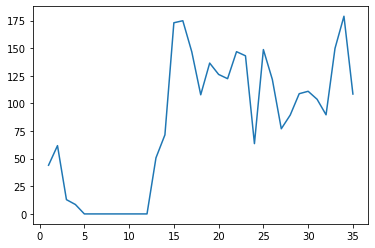

In [112]:
#类型
r_c = data.groupby(['cat_f','time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

for f in list(set(data['cat_f'])):
	x=r_c[r_c['cat_f']==f]['time_id']
	y=r_c[r_c['cat_f']==f]['sum']
	plt.plot(x,y,label=str(f))
	plt.show()

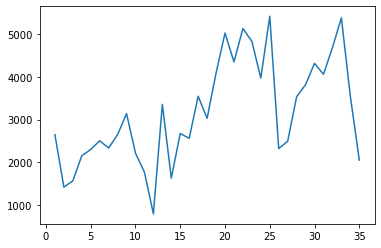

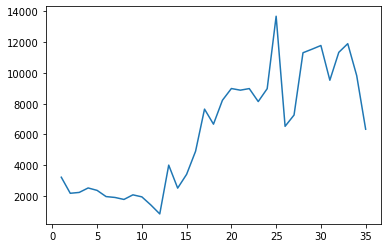

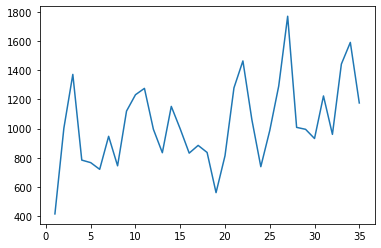

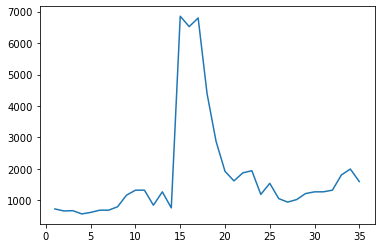

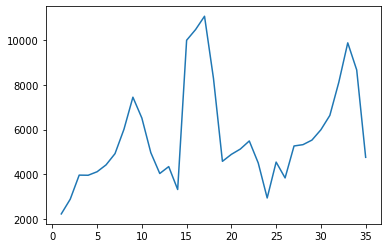

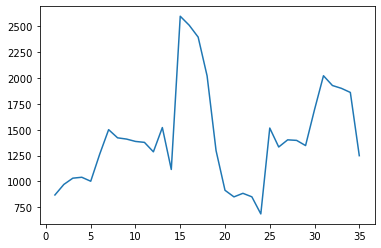

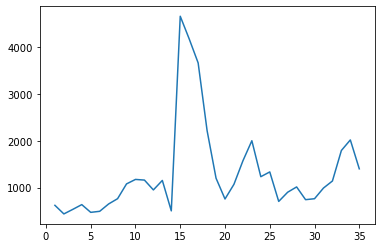

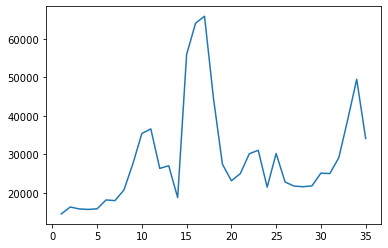

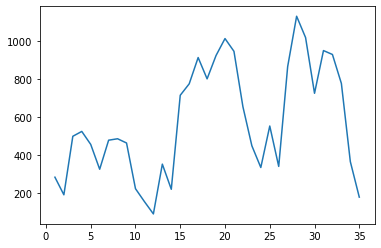

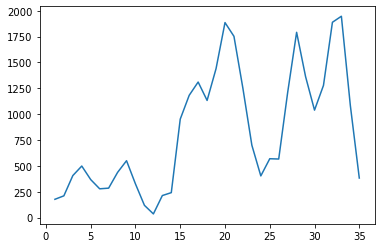

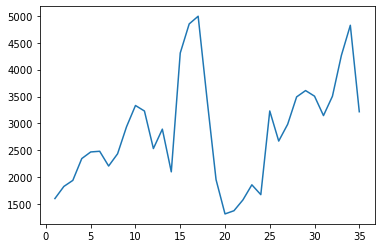

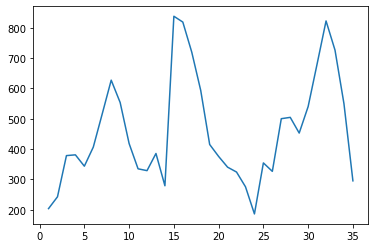

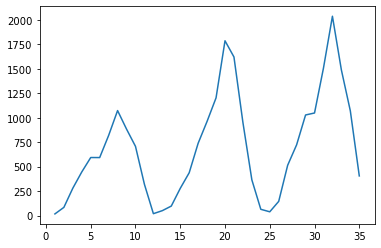

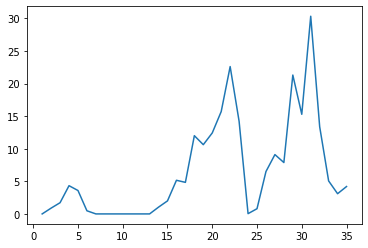

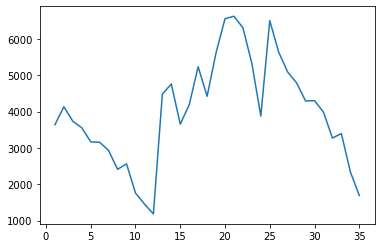

In [113]:
#品类
r_p = data.groupby(['cat_son','time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

for f in list(set(data['cat_son'])):
	x=r_p[r_p['cat_son']==f]['time_id']
	y=r_p[r_p['cat_son']==f]['sum']
	plt.plot(x,y,label=str(f))
	plt.show()

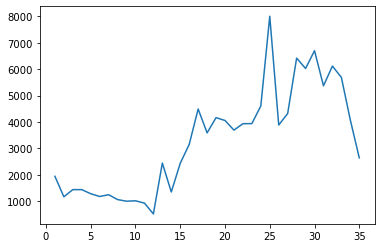

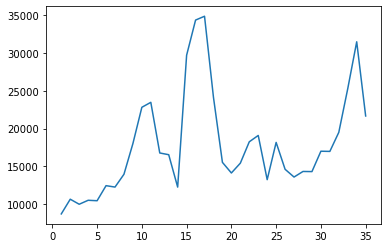

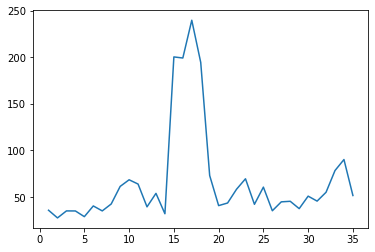

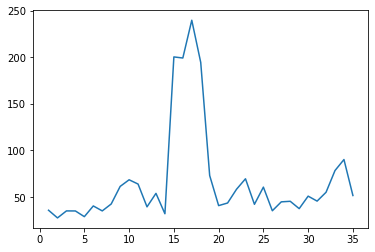

In [117]:
# 看一下部分物料情况
#物料
r_m = data.groupby(['m_code','time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

for f in [1031,1186,1054,1010,1010]:
	x=r_m[r_m['m_code']==f]['time_id']
	y=r_m[r_m['m_code']==f]['sum']
	plt.plot(x,y,label=str(f))
	plt.show()

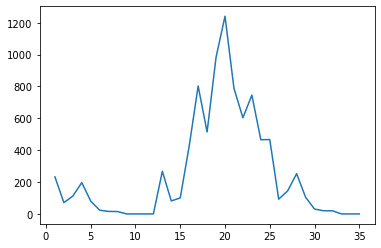

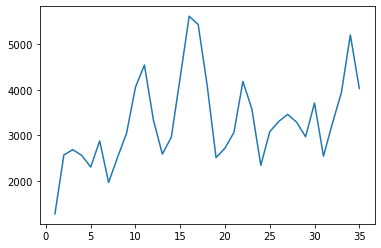

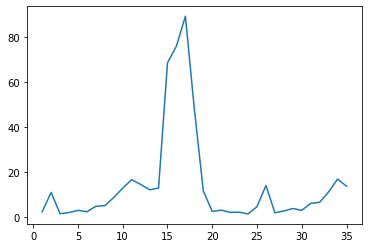

In [118]:
# 看一下部分物料情况
#物料
r_m = data.groupby(['id','time_id']).agg({'label':'sum'}).rename(columns={'label':'sum'}).reset_index()

for f in ['20101031','20141186','20111054','20041010','20011010']:
	x=r_m[r_m['id']==f]['time_id']
	y=r_m[r_m['id']==f]['sum']
	plt.plot(x,y,label=str(f))
	plt.show()

In [6]:
pd.pivot_table(data,index=['f_code','time_id'],values='label',aggfunc=np.sum)

label
f_code time_id         
2000   1        8391.07
       2        5868.67
       3        8032.01
       4        8599.49
       5        8671.41
...                 ...
2015   31       2232.02
       32       2640.87
       33       3421.81
       34       3930.90
       35       2413.30

[537 rows x 1 columns]